Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.0173 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - loss: 0.0018 - val_loss: 6.2186e-04 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - loss: 0.0014 - val_loss: 5.7731e-04 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - loss: 0.0012 - val_loss: 5.9533e-04 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - loss: 0.0013 - val_loss: 6.9411e-04 - learning_rate: 0.0010
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - loss: 0.0014 - val_loss: 6.7395e-04 - learning_rate: 0.0010
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - loss: 0.0011 - val_loss: 5.7505e-04 - learning_rate: 0.0010
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - loss: 0.0011 - val_loss: 5.5636e-04 - learning_rate: 5.0000e-04
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - loss: 9

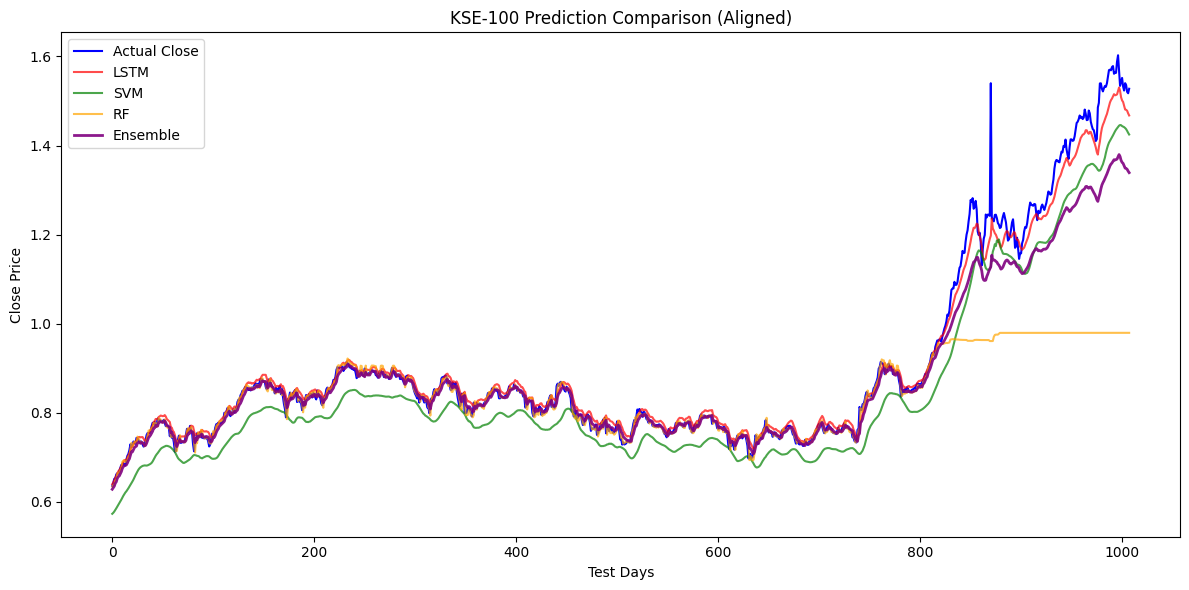

In [ ]:

# KSE-100 Prediction Full Pipeline
# LSTM + RF + SVM + Ensemble
# Optimized & Cleaned


#Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
import joblib
import talib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

file_path = "/content/drive/MyDrive/KSE100-20years.csv"
df = pd.read_csv(file_path, parse_dates=["Date"])
df = df.sort_values("Date")
df = df[["Date","Open","High","Low","Close","Volume"]].dropna()

# Ensure numeric
for col in ["Open","High","Low","Close","Volume"]:
    if df[col].dtype=="object":
        df[col] = df[col].str.replace(",","").astype(float)

# Technical Indicators (TA-Lib) 
df["MA5"] = df["Close"].rolling(5).mean()
df["MA10"] = df["Close"].rolling(10).mean()
df["MA20"] = df["Close"].rolling(20).mean()
df["MA50"] = df["Close"].rolling(50).mean()
df["STD10"] = df["Close"].rolling(10).std()
df["STD20"] = df["Close"].rolling(20).std()
df["Return"] = df["Close"].pct_change()
df["Momentum"] = df["Close"] - df["Close"].shift(10)

df["RSI"] = talib.RSI(df["Close"].values, timeperiod=14)
macd, macdsignal, macdhist = talib.MACD(df["Close"].values, fastperiod=12, slowperiod=26, signalperiod=9)
df["MACD"], df["MACDSignal"], df["MACDHist"] = macd, macdsignal, macdhist
upper, middle, lower = talib.BBANDS(df["Close"].values, timeperiod=20)
df["BB_upper"], df["BB_middle"], df["BB_lower"] = upper, middle, lower

# Lag features
for lag in range(1,31):
    df[f"lag_{lag}"] = df["Close"].shift(lag)

df = df.dropna().reset_index(drop=True)

# Feature sets
features_lstm = ["Close","MA5","MA10","MA20","MA50","STD10","STD20","Return","Momentum",
                 "RSI","MACD","MACDSignal","MACDHist","BB_upper","BB_middle","BB_lower"]
features_ml = features_lstm + [f"lag_{i}" for i in range(1,31)]

# Train/Test Split (80/20) 
split_idx = int(0.8*len(df))
train_lstm = df.iloc[:split_idx][features_lstm].values
test_lstm  = df.iloc[split_idx:][features_lstm].values

#  Scaling & Sequences for LSTM 
scaler_lstm = MinMaxScaler()
train_lstm_scaled = scaler_lstm.fit_transform(train_lstm)
test_lstm_scaled  = scaler_lstm.transform(test_lstm)

def make_seq(arr, lookback=60):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i])
        y.append(arr[i,0])
    return np.array(X), np.array(y)

lookback = 60
X_train_lstm, y_train_lstm = make_seq(train_lstm_scaled, lookback)
seed = train_lstm_scaled[-lookback+1:]
stacked_test = np.vstack([seed, test_lstm_scaled])
X_test_lstm, y_test_lstm = make_seq(stacked_test, lookback)

# Target scaler
y_scaler_lstm = MinMaxScaler()
y_train_scaled = y_scaler_lstm.fit_transform(y_train_lstm.reshape(-1,1))
y_test_scaled  = y_scaler_lstm.transform(y_test_lstm.reshape(-1,1))

#  Build LSTM Model (BiLSTM+GRU)
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")
]

history = model.fit(X_train_lstm, y_train_scaled, epochs=10, batch_size=32,
                    validation_split=0.1, callbacks=callbacks, verbose=1)

pred_scaled = model.predict(X_test_lstm, verbose=0).ravel()
pred_lstm = y_scaler_lstm.inverse_transform(pred_scaled.reshape(-1,1)).ravel()
true_lstm = y_scaler_lstm.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

#  ML Branch (RF & SVM) 

train_ml = df.iloc[:split_idx][features_ml].values
test_ml  = df.iloc[split_idx:][features_ml].values

scaler_ml = MinMaxScaler()
train_ml_scaled = scaler_ml.fit_transform(train_ml)
test_ml_scaled  = scaler_ml.transform(test_ml)

def create_ml_sequences(dataset, target_col=0, lookback=60):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i,:])
        y.append(dataset[i,target_col])
    return np.array(X), np.array(y)

X_train_ml_3d, y_train_ml = create_ml_sequences(train_ml_scaled, target_col=0, lookback=lookback)
seed_ml = train_ml_scaled[-lookback:]
X_test_ml_3d, y_test_ml = create_ml_sequences(np.vstack([seed_ml, test_ml_scaled]), target_col=0, lookback=lookback)
X_test_ml_3d = X_test_ml_3d[-len(test_ml_scaled):]
y_test_ml = y_test_ml[-len(test_ml_scaled):]

# Flatten for classical ML

X_train_ml = X_train_ml_3d.reshape(X_train_ml_3d.shape[0], -1)
X_test_ml  = X_test_ml_3d.reshape(X_test_ml_3d.shape[0], -1)

# Feature selection via RF importance

temp_rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
temp_rf.fit(X_train_ml, y_train_ml)
top_features_idx = np.argsort(temp_rf.feature_importances_)[-100:]
X_train_ml_sel = X_train_ml[:, top_features_idx]
X_test_ml_sel  = X_test_ml[:, top_features_idx]

# Scale target for ML branch
y_scaler_ml = MinMaxScaler()
y_train_ml_scaled = y_scaler_ml.fit_transform(y_train_ml.reshape(-1,1)).ravel()

#  GridSearch SVR 
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {"C":[1,10,100,200,500,1000], "gamma":[1e-3,1e-2,5e-2,0.1], "kernel":["rbf"]}
grid_svm = GridSearchCV(SVR(), param_grid, cv=tscv, scoring="r2", n_jobs=-1)
grid_svm.fit(X_train_ml_sel, y_train_ml_scaled)
svm_model = grid_svm.best_estimator_
svm_pred_scaled = svm_model.predict(X_test_ml_sel)
svm_pred = y_scaler_ml.inverse_transform(svm_pred_scaled.reshape(-1,1)).ravel()

# -Random Forest
rf_model = RandomForestRegressor(
    n_estimators=1000, max_depth=25, min_samples_split=5, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train_ml_sel, y_train_ml_scaled)
rf_pred_scaled = rf_model.predict(X_test_ml_sel)
rf_pred = y_scaler_ml.inverse_transform(rf_pred_scaled.reshape(-1,1)).ravel()

# Align predictions & Ensemble 
L = min(len(true_lstm), len(y_test_ml), len(pred_lstm), len(svm_pred), len(rf_pred))
true_aligned = y_test_ml[-L:]
lstm_aligned = pred_lstm[-L:]
svm_aligned  = svm_pred[-L:]
rf_aligned   = rf_pred[-L:]

ensemble_pred = 0.6*lstm_aligned + 0.25*rf_aligned + 0.15*svm_aligned

# Evaluation Functions 
def evaluate_model(name, true, pred):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    print(f"\n{name} Performance:")
    print(f"MAE  = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")

evaluate_model("LSTM", true_aligned, lstm_aligned)
evaluate_model("SVM", true_aligned, svm_aligned)
evaluate_model("RF", true_aligned, rf_aligned)
evaluate_model("Ensemble", true_aligned, ensemble_pred)

#  Visualization 

plt.figure(figsize=(12,6))
plt.plot(true_aligned, label="Actual Close", color='blue')
plt.plot(lstm_aligned, label="LSTM", color='red', alpha=0.7)
plt.plot(svm_aligned, label="SVM", color='green', alpha=0.7)
plt.plot(rf_aligned, label="RF", color='orange', alpha=0.7)
plt.plot(ensemble_pred, label="Ensemble", color='purple', alpha=0.9, linewidth=2)
plt.title("KSE-100 Prediction Comparison (Aligned)")
plt.xlabel("Test Days")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
!apt-get install -y libta-lib0 libta-lib0-dev
!pip install TA-Lib


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0
E: Unable to locate package libta-lib0-dev
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 17.8 MB/s eta 0:00:00
